In [1]:
import tensorflow as tf

import numpy as np
import pickle
import os

In [2]:
img_size = 32 # width, height of image
num_channels = 3 # RGB 3channel
img_size_flat = img_size * img_size * num_channels # the number of the value of one image
num_classes = 10 # the class of images

_num_files_train = 5 # the number of train set
_images_per_file = 10000 # the number of image of one train set
_num_images_train = _num_files_train * _images_per_file # the number of total images of train sets

def one_hot_encoded(class_numbers, num_classes=None):
    if num_classes is None:
        num_classes = np.max(class_numbers) - 1
    return np.eye(num_classes, dtype=float)[class_numbers]

def _unpickle(filename):
    print("Loading data: " + filename)
    with open(filename, mode='rb') as file:
        data = pickle.load(file, encoding='bytes')
    return data

def _convert_images(raw):
    raw_float = np.array(raw, dtype=float) / 255.0 # convert data type (bytes to float)
    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size]) # reshape the array to [image_number, channel, height, width]
    images = images.transpose([0, 2, 3, 1]) # reorder the array to [image_number, height, width, channel]
    return images

def _load_data(filename):
    data = _unpickle(filename) # load the pickled data file
    raw_images = data[b'data'] # get the raw images
    cls = np.array(data[b'labels']) # get the class-numbers
    images = _convert_images(raw_images) # convert the images
    return images, cls

def load_class_names():
    # Load the class-names from the pickled file.
    data = _unpickle(filename="batches.meta") # load the pickled data file
    raw = data[b'label_names'] # get the name of classes
    names = [x.decode('utf-8') for x in raw] # convert from binary strings
    return names

def load_training_data():
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float) # pre-allocation
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # merge train sets
    begin = 0 # train set begin index
    for i in range(_num_files_train): # for each train set
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1)) # load the images and class-numbers
        num_images = len(images_batch) # the number of images in this train set
        end = begin + num_images # train set end index
        images[begin:end, :] = images_batch # split the images and store into the array
        cls[begin:end] = cls_batch # split the class-numbers and store into the array
        begin = end # prepare the next train set
    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

def load_test_data():
    images, cls = _load_data(filename="test_batch")
    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

In [3]:
import matplotlib.pyplot as plt
cls_names = load_class_names()

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = cls_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


Loading data: batches.meta


In [4]:
images_train, cls_train, cls_train_one_hot = load_training_data()
images_test, cls_test, cls_test_one_hot = load_test_data()
# cls_names = load_class_names()

Loading data: data_batch_1
Loading data: data_batch_2
Loading data: data_batch_3
Loading data: data_batch_4
Loading data: data_batch_5
Loading data: test_batch


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


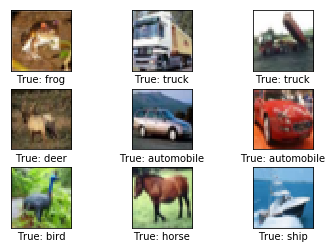

In [5]:
print(cls_names)

# Get the first images from the test-set.
images = images_train[0:9]

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)


In [6]:
print(cls_train)
print(cls_train.shape)
print(images_train.shape)
print(cls_train_one_hot.shape)

[6 9 9 ..., 9 1 1]
(50000,)
(50000, 32, 32, 3)
(50000, 10)


In [7]:
def weight_variable(shape):
    """
    < tf.truncated_normal >
    
    The generated values follow a normal distribution 
    with specified mean and standard deviation, 
    except that values whose magnitude is more than 2 standard deviations 
    from the mean are dropped and re-picked.
    """
    initial = tf.truncated_normal(shape, stddev=0.1) # 가우시안 분포를 따르며, 분산이 2이상이면 버리고 다시 random pick
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape) # biases = 0.1
    return tf.Variable(initial)

def conv2d(x, W):
    """
    x (input feature maps) : [num_batch, height, width, in_channel]
    # 순서는 batch, channel, height, width 로 하는게 일반적이지만 Tensorflow는 batch, height, width, channel이 default
    # 바뀔 예정, format으로 바꿀 수 있음
    # Tensorflow는 CUDNN으로 되어있는데 CUDNN은 n, c, w, h 순서 n은 batch
    # Tensorflow는 분산컴퓨팅 위주로 만들었기 때문에 바뀐것
    # Tensorflow 방식대로 넣으면 느리고, format으로 바꿔야 빨라짐 - CUDNN과 일치
    W (convolution filter): [filter_height, filter_width, in_channel, out_channel]
    return (output feature maps): [num_batch, height, width, out_channel]
    """
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    # batch (height, width), channel stride 순서 - 1이면 버리는게 없다는 것, zero Padding이 'SAME', 'VALID'는 Valid convolution
    # 숫자, 크기를 확실히 알아야 함 - 디자인할 때 중요

def max_pool_2x2(x):
    """
    x (input feature maps) : [num_batch, height, width, channel]
    ksize (window size) : [window_batch, window_height, window_width, window_channel] # pooling할 윈도우 크기
    # batch, channel 에서도 pooling 가능 - 일반적으로 general하게 만들어 놓은 것, 보통은 이미지, map안에서만 pooling
    return (output feature maps) : [num_batch, height/2, width/2, channel] # stride를 통해 나온 출력 map의 크기, height, width 1/2로
    """
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def max_pool_2x2_nst(x):
    """
    x (input feature maps) : [num_batch, height, width, channel]
    ksize (window size) : [window_batch, window_height, window_width, window_channel] # pooling할 윈도우 크기
    # batch, channel 에서도 pooling 가능 - 일반적으로 general하게 만들어 놓은 것, 보통은 이미지, map안에서만 pooling
    return (output feature maps) : [num_batch, height/2, width/2, channel] # stride를 통해 나온 출력 map의 크기, height, width 1/2로
    """
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 1, 1, 1], padding='SAME')

In [8]:
# Convolutional Neural Networks Model
x = tf.placeholder(tf.float32, [None, img_size,img_size,num_channels])
x_image = x
# 파일을 읽으면 그냥 vector form으로 들어오기 때문에 sparse connectivity를 쓰기 위해서는 reshape로 정리가 필요하지만,
# 이미 파일을 읽을 때 reshape 되서 들어오기 때문에 그대로 사용

with tf.name_scope("layer11") as scope:
    W_1conv1 = weight_variable([3, 3, 3, 96])                            
    b_1conv1 = bias_variable([96])
    h_1conv1 = tf.nn.relu(conv2d(x_image, W_1conv1) + b_1conv1)   # [None, 32, 32, 96]
# bias를 각 픽셀(데이터)마다 넣을 수도 있음 bias[28,28,32]

    W_1conv1_hist = tf.summary.histogram("weights11", W_1conv1)
    b_1conv1_hist = tf.summary.histogram("biases11", b_1conv1)
    h_1conv1_hist = tf.summary.histogram("h_conv11", h_1conv1)

with tf.name_scope("layer12") as scope:
    W_1conv = weight_variable([3, 3, 96, 96])
    b_1conv = bias_variable([96])
    h_1conv = tf.nn.relu(conv2d(h_1conv1, W_1conv) + b_1conv)   # [None, 32, 32, 96]
    h_1pool = max_pool_2x2(h_1conv)                            # [None, 16, 16, 96]

    W_1conv_hist = tf.summary.histogram("weights12", W_1conv)
    b_1conv_hist = tf.summary.histogram("biases12", b_1conv)
    h_1conv_hist = tf.summary.histogram("h_conv12", h_1conv)
    h_1pool_hist = tf.summary.histogram("h_pool12", h_1pool)


with tf.name_scope("layer21") as scope:
    W_2conv1 = weight_variable([3, 3, 96, 192])
    b_2conv1 = bias_variable([192])
    h_2conv1 = tf.nn.relu(conv2d(h_1pool, W_2conv1) + b_2conv1)   # [None, 16, 16, 192]

    W_2conv1_hist = tf.summary.histogram("weights21", W_2conv1)
    b_2conv1_hist = tf.summary.histogram("biases21", b_2conv1)
    h_2conv1_hist = tf.summary.histogram("h_conv21", h_2conv1)

with tf.name_scope("layer22") as scope:
    W_2conv = weight_variable([3, 3, 192, 192])
    b_2conv = bias_variable([192])
    h_2conv = tf.nn.relu(conv2d(h_2conv1, W_2conv) + b_2conv)   # [None, 16, 16, 192]
    h_2pool = max_pool_2x2(h_2conv)                            # [None, 8, 8, 192]

    W_2conv_hist = tf.summary.histogram("weights22", W_2conv)
    b_2conv_hist = tf.summary.histogram("biases22", b_2conv)
    h_2conv_hist = tf.summary.histogram("h_conv22", h_2conv)
    h_2pool_hist = tf.summary.histogram("h_pool22", h_2pool)


with tf.name_scope("layer31") as scope:
    W_3conv1 = weight_variable([3, 3, 192, 384])
    b_3conv1 = bias_variable([384])
    h_3conv1 = tf.nn.relu(conv2d(h_2pool, W_3conv1) + b_3conv1)   # [None, 8, 8, 384]

    W_3conv1_hist = tf.summary.histogram("weights31", W_3conv1)
    b_3conv1_hist = tf.summary.histogram("biases31", b_3conv1)
    h_3conv1_hist = tf.summary.histogram("h_conv31", h_3conv1)

with tf.name_scope("layer32") as scope:
    W_3conv = weight_variable([3, 3, 384, 384])
    b_3conv = bias_variable([384])
    h_3conv = tf.nn.relu(conv2d(h_3conv1, W_3conv) + b_3conv)   # [None, 8, 8, 384]
    h_3pool = max_pool_2x2(h_3conv)                            # [None, 4, 4, 384]

    W_3conv_hist = tf.summary.histogram("weights32", W_3conv)
    b_3conv_hist = tf.summary.histogram("biases32", b_3conv)
    h_3conv_hist = tf.summary.histogram("h_conv32", h_3conv)
    h_3pool_hist = tf.summary.histogram("h_pool32", h_3pool)


with tf.name_scope("layer4") as scope:
    W_fc1 = weight_variable([4 * 4 * 384, 1024])              
    b_fc1 = bias_variable([1024])
    h_3pool_flat = tf.reshape(h_3pool, [-1, 4 * 4 * 384]) # batch는 None(-1)
    h_fc1 = tf.nn.relu(tf.matmul(h_3pool_flat, W_fc1) + b_fc1) # [None, 1024]

    W_fc1_hist = tf.summary.histogram("W_fc1", W_fc1)
    b_fc1_hist = tf.summary.histogram("b_fc1", b_fc1)
    h_3pool_flat_hist = tf.summary.histogram("h_3pool_flat", h_3pool_flat)
    h_fc1_hist = tf.summary.histogram("h_fc1", h_fc1)

with tf.name_scope("layer5") as scope:
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    y = tf.matmul(h_fc1, W_fc2) + b_fc2                        # [None, 10]

    W_fc2_hist = tf.summary.histogram("W_fc2", W_fc2)
    b_fc2_hist = tf.summary.histogram("b_fc2", b_fc2)
    y_hist = tf.summary.histogram("y_hat", y)

In [9]:
# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

with tf.name_scope("cost") as scope:
#     cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    cross_entropy = - tf.reduce_mean(y_ * tf.log(tf.clip_by_value(y, 1e-10, 1.0)) + (1-y_) * tf.log(tf.clip_by_value(1-y, 1e-10, 1.0))) 
    cross_entropy_summ = tf.summary.scalar("cross_entropy", cross_entropy)

with tf.name_scope("train") as scope:
    train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)

In [10]:
# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_summ = tf.summary.scalar("accuracy", accuracy)

In [11]:
sess = tf.InteractiveSession()
# with tf.Session() as sess:

# tensorboard --logdir=./logs/project1_CIFAR-10
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./logs/project1_CIFAR-10")
writer.add_graph(sess.graph)  # Show the graph

tf.global_variables_initializer().run()

# Train
num_epoch = 1
for e in range(num_epoch):
    print(e+1, 'th epoch (', (e+1)*_num_images_train, ')');
    num_batch = 500 # the number of images of one batch
    num_batch_test = 100
    index_train = 0
    index_test = 0
    acc_val = np.zeros(shape=[10], dtype=float)
    #_num_files_train*_images_per_file/num_batch
    for i in range(100):
        print(e+1, 'th epoch, ', i+1, 'th batch (', (i+1)*num_batch, ')');
        xs = images_train[index_train:(i+1)*num_batch]
        ys = cls_train_one_hot[index_train:(i+1)*num_batch]
        index_train = (i+1)*num_batch
        summary, cost_val, y_val, _ = sess.run([merged_summary, cross_entropy, y, train_step], feed_dict={x: xs, y_: ys})
        writer.add_summary(summary, global_step=(i+1)*num_batch)
        print('cross_entropy :', cost_val)
        if i%10 == 9:
            num_test = sess.run(tf.cast(((i+1)/10), tf.int32))
            print('@', num_test, 'th test (', (i+1)*num_batch_test, ')');
            xs_test = images_test[0:1000]
            ys_test = cls_test_one_hot[0:1000]
#             xs_test = images_test[index_test:(i+1)*num_batch_test]
#             ys_test = cls_test_one_hot[index_test:(i+1)*num_batch_test]
#             index_test = (i+1)*num_batch_test
            acc_val[num_test-1] = sess.run(accuracy, feed_dict={x: xs_test, y_: ys_test})
            print('accuracy (1000) : ', 1-acc_val[num_test-1])

1 th epoch ( 50000 )
1 th epoch,  1 th batch ( 500 )
cross_entropy : 11.3747
1 th epoch,  2 th batch ( 1000 )
cross_entropy : 11.3518
1 th epoch,  3 th batch ( 1500 )
cross_entropy : 11.2643
1 th epoch,  4 th batch ( 2000 )
cross_entropy : 11.1679
1 th epoch,  5 th batch ( 2500 )
cross_entropy : 9.68001
1 th epoch,  6 th batch ( 3000 )
cross_entropy : 9.79053
1 th epoch,  7 th batch ( 3500 )
cross_entropy : 9.73527
1 th epoch,  8 th batch ( 4000 )
cross_entropy : 9.6708
1 th epoch,  9 th batch ( 4500 )
cross_entropy : 9.58791
1 th epoch,  10 th batch ( 5000 )
cross_entropy : 9.70353
@ 1 th test ( 1000 )
accuracy (1000) :  0.894000001252
1 th epoch,  11 th batch ( 5500 )
cross_entropy : 9.67105
1 th epoch,  12 th batch ( 6000 )
cross_entropy : 9.77711
1 th epoch,  13 th batch ( 6500 )
cross_entropy : 9.62475
1 th epoch,  14 th batch ( 7000 )
cross_entropy : 9.51883
1 th epoch,  15 th batch ( 7500 )
cross_entropy : 9.5465
1 th epoch,  16 th batch ( 8000 )
cross_entropy : 9.65238
1 th epo

In [12]:
# after weight update
index_test = 0
acc_val = np.zeros(shape=[10], dtype=float)
for i in range(100):
    if i%10 == 9:
        num_test = sess.run(tf.cast(((i+1)/10), tf.int32))
        print(num_test, 'th test (', (i+1)*num_batch_test, ')');
        xs_test = images_test[index_test:(i+1)*num_batch_test]
        ys_test = cls_test_one_hot[index_test:(i+1)*num_batch_test]
        index_test = (i+1)*num_batch_test
        acc_val[num_test-1] = sess.run(accuracy, feed_dict={x: xs_test, y_: ys_test})
        print('accuracy : ', 1-acc_val[num_test-1])

#print(sess.run(y, feed_dict={x: xs}))
print(1-acc_val)
acc_mean = tf.reduce_mean(acc_val)
print('accuracy (10000) : ', 1-sess.run(acc_mean))

1 th test ( 1000 )
accuracy :  0.895999997854
2 th test ( 2000 )
accuracy :  0.906999997795
3 th test ( 3000 )
accuracy :  0.905000001192
4 th test ( 4000 )
accuracy :  0.907999999821
5 th test ( 5000 )
accuracy :  0.88599999994
6 th test ( 6000 )
accuracy :  0.898999996483
7 th test ( 7000 )
accuracy :  0.898999996483
8 th test ( 8000 )
accuracy :  0.903999999166
9 th test ( 9000 )
accuracy :  0.898000001907
10 th test ( 10000 )
accuracy :  0.916000001132
[ 0.896  0.907  0.905  0.908  0.886  0.899  0.899  0.904  0.898  0.916]
accuracy (10000) :  0.901799999177
